In [3]:
import numpy as np
from scipy.integrate import quad, odeint, solve_ivp
from scipy.special import kn
import matplotlib.pyplot as plt
import math
from numpy import cos, sin, pi, sqrt

import lib.config as config

from importlib import reload

import lib.utils
import lib.Xsecs
import lib.cosmo_def

In [70]:
mNval = 10

ml = 1.73e-8
#ml = 5.06e-8
DeltaM21Sq = 7.51e-17
DeltaM31Sq = 2.55e-15

##############################
### Assign input variables ###
##############################

config.config_params['Lnu'] = 1e-2#1.38e-1/3
config.config_params['Lchi'] = 3e-3
config.config_params['chi_flav'] = 1

config.config_params['m_nl1'] = ml
config.config_params['m_nl2'] = sqrt(ml**2 + DeltaM21Sq)
config.config_params['m_nl3'] = sqrt(ml**2 + DeltaM31Sq)

config.config_params['mN1'] = mNval
config.config_params['mN2'] = mNval
config.config_params['mN3'] = mNval

config.config_params['Mass_phi'] = 1e-2
config.config_params['Mass_chi'] = 1e-12


Lnu = config.config_params['Lnu']
Lchi = config.config_params['Lchi']

m_nl1 = config.config_params['m_nl1']
m_nl2 = config.config_params['m_nl2']
m_nl3 = config.config_params['m_nl3']

mN1 = config.config_params['mN1']
mN2 = config.config_params['mN2']
mN3 = config.config_params['mN3']

Mass_phi = config.config_params['Mass_phi']
Mass_chi = config.config_params['Mass_chi']

chi_flav = config.config_params['chi_flav']


reload(lib.utils)
reload(lib.Xsecs)
reload(lib.cosmo_def)

from lib.utils import *
from lib.Xsecs import *
from lib.cosmo_def import *

# Decay width of phi
phi_decayW = decayWidth_phi(chi_flav, Lchi, Mass_phi)

# G_eff of chi SI
Geffchi = Geffchi(Lchi, Mass_phi)

print(m_nl1+m_nl2+m_nl3, 3e-8*3)

9.002790127518503e-08 8.999999999999999e-08


In [71]:
# Differential Equations of Temperature

def dTy_dt(Ty, Tnu_e, Tnu_mu, Tchi):
    numer = -1*(Hubble(Ty, Tnu_e, Tnu_mu, Tchi, chi_flav, Mass_phi)*(4*rho_y(Ty) + 3*(rho_e(Ty)+P_e(Ty))) # + dP_int later
                + delrho_nu_delt(Ty, Tnu_e, Tnu_mu, Tchi, e_or_mu='e') 
                + 2*delrho_nu_delt(Ty, Tnu_e, Tnu_mu, Tchi, e_or_mu='mu')
                )
    denomi = drho_y_dT(Ty)+drho_e_dT(Ty)
    return numer/denomi

def dTnu_e_dt(Ty, Tnu_e, Tnu_mu, Tchi):
    numer = (-4*Hubble(Ty, Tnu_e, Tnu_mu, Tchi, chi_flav, Mass_phi)*rho_nu(Tnu_e)
             + delrho_nu_delt(Ty, Tnu_e, Tnu_mu, Tchi, e_or_mu = 'e')
             + 4*1/2*delrho_vi_delT_chi(Tnu_e, Tchi,
                                        Lnu, chi_flav, Lchi, Mass_phi,
                                        flav1 = 'e', flav2 = 'e')       # 4(internal dof) * symmetrization factor (1/2 x 1/2 x 2)
             + 4*1/2*1/2*delrho_vi_delT_chi(Tnu_e, Tchi,
                                            Lnu, chi_flav, Lchi, Mass_phi,
                                            flav1 = 'e', flav2 = 'mu')  # 4(internal dof) * symmetrization factor (1/2 x 1/2)
             
             # E transfer of nu nu -> phi phi -> 4 chi 
             # phi immediately decays, dominated by on shell phi
             + (4*1/2*delrho_vi_delT_phi(Tnu_e, Tchi, 
                                         Lnu, Mass_phi, m_nl1, mN1, mN2, mN3, 
                                         flav1 = 'e', flav2 = 'e') 
                + 4*1/2*1/2*delrho_vi_delT_phi(Tnu_e, Tchi, 
                                               Lnu, Mass_phi, m_nl1, mN1, mN2, mN3, 
                                               flav1 = 'e', flav2 = 'mu')
               )
            )
    denomi = drho_nu_dT(Tnu_e)
    return numer/denomi

def dTnu_mu_dt(Ty, Tnu_e, Tnu_mu, Tchi):
    numer = (-8*Hubble(Ty, Tnu_e, Tnu_mu, Tchi, chi_flav, Mass_phi)*rho_nu(Tnu_mu)
             + 2*delrho_nu_delt(Ty, Tnu_e, Tnu_mu, Tchi, e_or_mu = 'mu')
             + 2*(4*1/2*delrho_vi_delT_chi(Tnu_mu, Tchi, 
                                           Lnu, chi_flav, Lchi, Mass_phi, 
                                           flav1 = 'mu', flav2 = 'mu'))    # 4(internal dof) * symmetrization factor (1/2 x 1/2 x 2)
             + 2*(4*1/2*1/2*delrho_vi_delT_chi(Tnu_e, Tchi, 
                                               Lnu, chi_flav, Lchi, Mass_phi, 
                                               flav1 = 'e', flav2 = 'mu')) # 4(internal dof) * symmetrization factor (1/2 x 1/2)

             # E transfer of nu nu -> phi phi -> 4 chi 
             # phi immediately decays, dominated by on shell phi
             + 2*(4*1/2*delrho_vi_delT_phi(Tnu_e, Tchi, 
                                           Lnu, Mass_phi, m_nl1, mN1, mN2, mN3, 
                                           flav1 = 'mu', flav2 = 'mu') 
                  +2* 4*1/2*1/2*delrho_vi_delT_phi(Tnu_e, Tchi, 
                                                   Lnu, Mass_phi, m_nl1, mN1, mN2, mN3, 
                                                   flav1 = 'e', flav2 = 'mu')
                 )
             )
    denomi = 2*drho_nu_dT(Tnu_mu)
    return numer/denomi

def dTchi_dt(Ty, Tnu_e, Tnu_mu, Tchi):
    numer = (- 4*Hubble(Ty, Tnu_e, Tnu_mu, Tchi, chi_flav, Mass_phi)*rho_chi(Tchi, chi_flav)
             - 4*1/2*delrho_vi_delT_chi(Tnu_e, Tchi, 
                                        Lnu, chi_flav, Lchi, Mass_phi, flav1 = 'e', flav2 = 'e')
             - 2*(4*1/2*delrho_vi_delT_chi(Tnu_mu, Tchi, 
                                           Lnu, chi_flav, Lchi, Mass_phi, flav1 = 'mu', flav2 = 'mu'))
             - 3*(4*1/2*1/2*delrho_vi_delT_chi(Tnu_e, Tchi, 
                                               Lnu, chi_flav, Lchi, Mass_phi, flav1 = 'e', flav2 = 'mu'))
            )
    denomi = drho_chi_dT(Tchi, chi_flav)

    # E transfer of nu nu -> phi phi -> 4 chi 
    # phi immediately decays, dominated by on shell phi
    BSM_phi_prod = (- 4*1/2*delrho_vi_delT_phi(Tnu_e, Tchi,
                                               Lnu, Mass_phi, m_nl1, mN1, mN2, mN3, 
                                               flav1 = 'e', flav2 = 'e') 
                    - 2*(4*1/2*delrho_vi_delT_phi(Tnu_e, Tchi, 
                                                  Lnu, Mass_phi, m_nl1, mN1, mN2, mN3, 
                                                  flav1 = 'mu', flav2 = 'mu'))
                    - 3*(4*1/2*1/2*delrho_vi_delT_phi(Tnu_e, Tchi, 
                                                      Lnu, Mass_phi, m_nl1, mN1, mN2, mN3, 
                                                      flav1 = 'e', flav2 = 'mu'))
                   )
    
    return (numer + BSM_phi_prod)/denomi


# ODE
def dT_dt(Tvec, t):
    Ty, Tnu_e, Tnu_mu, Tchi = Tvec

    #Tfloor = 1e-8
    #Ty = max(Ty, Tfloor)
    #Tnu_e = max(Tnu_e, Tfloor)
    #Tnu_mu = max(Tnu_mu, Tfloor)
    #Tchi = max(Tchi, Tfloor)

    dTy = dTy_dt(Ty, Tnu_e, Tnu_mu, Tchi)
    dTnu_e = dTnu_e_dt(Ty, Tnu_e, Tnu_mu, Tchi)
    dTnu_mu = dTnu_mu_dt(Ty, Tnu_e, Tnu_mu, Tchi)
    dTchi = dTchi_dt(Ty, Tnu_e, Tnu_mu, Tchi)
    
    return (dTy, dTnu_e, dTnu_mu, dTchi)


# Neff Definition
def Neff_nu(Ty, Tnu_e, Tnu_mu):
    return 8/7*(11/4)**(4/3)* (rho_nu(Tnu_e) + 2*rho_nu(Tnu_mu))/rho_y(Ty)

def Neff(Ty, Tnu_e, Tnu_mu, Tchi):
    return 8/7*(11/4)**(4/3)* (rho_nu(Tnu_e) + 2*rho_nu(Tnu_mu) + rho_chi(Tchi, chi_flav))/rho_y(Ty)

In [72]:
print('SM neutrino-phi coupling = ',
      f"{Lnu*n_light_phi('1', '1'):.4}",', ',
      f"{Lnu*n_light_phi('2', '2'):.4}",', ',
      f"{Lnu*n_light_phi('3', '3'):.4}",'\n')

print('m tilde = ',Lnu*n_light_phi('1', '1')*mN1,'\n',
      f"{np.log10(Lnu*n_light_phi('1', '1')*mN1):.4}",'\n')

print('phi mass (MeV) = ',f"{Mass_phi:.4}")
print('phi decay width (MeV) = ', f"{phi_decayW:.3}",'\n')
print('decay width / mass = ', f"{phi_decayW/Mass_phi*100:.3} %",'\n')

print('cross section at mass pole : ',
      f"{Xsec_flav(Mass_phi**2, Lnu, chi_flav, Lchi, Mass_phi, flav1 = 'e', flav2 = 'e'):.4}", ', ',
      f"{Xsec_flav(Mass_phi**2, Lnu, chi_flav, Lchi, Mass_phi, flav1 = 'mu', flav2 = 'mu'):.4}",'\n')

print('Lambda phi chi = ',Lchi,'\n')

print('nu to chi energy density transfer rate : ',
      f"{4*1/2*delrho_vi_delT_chi(10,0.001, Lnu, chi_flav, Lchi, Mass_phi):.4}",', ',
      f"{4*1/2*delrho_vi_delT_chi(10,0.001, Lnu, chi_flav, Lchi, Mass_phi, flav1 = 'mu', flav2 = 'mu'):.4}",'\n')

print('nu to phi energy density transfer rate : ',
      f"{delrho_vi_delT_phi(10, 1e-3, Lnu, Mass_phi, m_nl1, mN1, mN2, mN3, flav1 = 'e', flav2 = 'e'):.4}",', ',
      f"{delrho_vi_delT_phi(10, 1e-3, Lnu, Mass_phi, m_nl1, mN1, mN2, mN3, flav1 = 'mu', flav2 = 'mu'):.4}",'\n')

print('mass matrix of light neutrinos \n', mass_nlight,'\n')
print('PMNS matrix \n',U_PMNS.real,'\n')

print('Geff = ',f"{Geffchi:0.3} ,  ", f"{np.log10(Geffchi):.3}")

SM neutrino-phi coupling =  1.73e-11 ,  1.935e-11 ,  5.338e-11 

m tilde =  1.7299999999999997e-10 
 -9.762 

phi mass (MeV) =  0.01
phi decay width (MeV) =  1.79e-09 

decay width / mass =  1.79e-05 % 

cross section at mass pole :  9.678e-12 ,  5.154e-11 

Lambda phi chi =  0.003 

nu to chi energy density transfer rate :  -7.462e-05 ,  -0.0003974 

nu to phi energy density transfer rate :  -0.0001924 ,  -0.0001427 

mass matrix of light neutrinos 
 [[1.73000000e-08 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.93491602e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 5.33787411e-08]] 

PMNS matrix 
 [[ 0.82549641  0.54452133  0.14849984]
 [-0.45421358  0.48474148  0.74747289]
 [ 0.3350309  -0.68448683  0.64748133]] 

Geff =  0.0822 ,   -1.09


In [73]:
#intial conditions Ty = Tv_i = 10 MeV , T_chi ~ small
T_init = np.concatenate((10 * np.ones(3), np.array([1e-4])))
t = np.logspace(np.log10(8e-3),np.log10(5e10), 600)

# ODE solve
sol = odeint(dT_dt, T_init, t, rtol = 1e-6, atol = 1e-6)

0.751



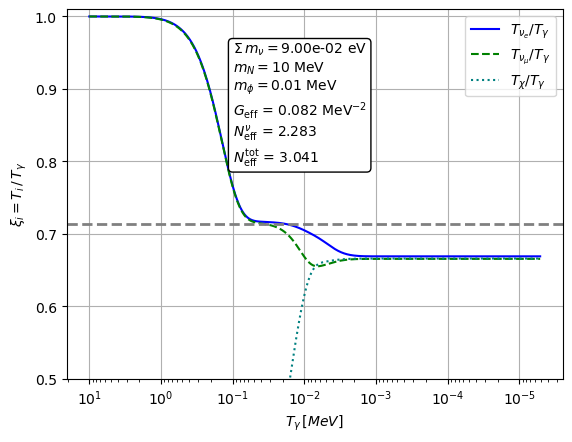

In [74]:
N_eff_nu = round(Neff_nu(sol[-1,0], sol[-1,1], sol[-1,2]),4)
N_eff_tot = round(Neff(sol[-1,0], sol[-1,1], sol[-1,2], sol[-1,3]),4)

print(f"{N_eff_nu/N_eff_tot:0.3}\n")

plt.plot(sol[:, 0], sol[:, 1]/sol[:, 0], 'b', label=r'$T_{\nu_e}/T_\gamma$')
plt.plot(sol[:, 0], sol[:, 2]/sol[:, 0], 'g', ls='dashed', label=r'$T_{\nu_\mu}/T_\gamma$')
plt.plot(sol[:, 0], sol[:, 3]/sol[:, 0], 'teal', ls='dotted', label=r'$T_{\chi}/T_\gamma$')


plt.axhline((4/11)**(1/3), c='gray', ls = 'dashed', lw = 2)

plt.legend(loc='best')
plt.xscale('log')
plt.gca().invert_xaxis()

plt.xlabel(r'$T_{\gamma}\, [MeV]$')
plt.ylabel(r'$\xi_i = T_i\,/\,T_\gamma$')

plt.text(1e-1, 0.8, 
         r"$\Sigma\, m_\nu = $"+f"{(m_nl1+m_nl2+m_nl3)*1e6:.2e} eV"
         +"\n"+r"$m_N = $"+f"{mN1} MeV"
         +"\n"+r"$m_\phi = $"+f"{Mass_phi:.3} MeV"
         +"\n"+r"$G_\text{eff}$ = "+f"{Geffchi:.2}"+" MeV$^{-2}$"
         +"\n"+r"$N^\nu_\text{eff}$ = "+f"{N_eff_nu:.4}"
         +"\n"+r"$N^\text{tot}_\text{eff}$ = "+f"{N_eff_tot:.4}", 
         color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

plt.ylim(0.5,1.01)

plt.grid()
plt.show()

In [65]:
import pickle

dictionary = {'phi-NN': Lnu,
              'M_phi': Mass_phi,
              'mtilde1': Lnu*n_light_phi('1', '1')*mN1,
              'mtilde2': Lnu*n_light_phi('2', '2')*mN1,
              'mtilde3': Lnu*n_light_phi('3', '3')*mN1,
              'decay_width_phi': phi_decayW,
              'T_photon': sol[:, 0],
              'T_nu_e': sol[:, 1], 
              'T_nu_mu': sol[:, 2],
              'T_chi': sol[:, 3]}


###### Saving... ######

path = '/Users/Tae/Desktop/N_effective/Type_I_variant/main_code_v2/data_m_scan/'

with open(path+f'Temperature_evolution_mN_{int(mN1)}_NH_split.pkl', 'wb') as f:
    pickle.dump(dictionary, f)



In [49]:
mNval = 10

with open(f'./data_m_scan/Temperature_evolution_mN_{mNval}_NH_split.pkl', 'rb') as f:
    data = pickle.load(f)

Ty_evnt = data['T_photon']
Tnu_e_evnt = data['T_nu_e']
Tnu_mu_evnt = data['T_nu_mu']
Tchi_evnt = data['T_chi']

time = np.logspace(np.log10(8e-3),np.log10(5e10), 600)

m_nl1 = data['mtilde1']/Lnu
m_nl2 = data['mtilde2']/Lnu
m_nl3 = data['mtilde3']/Lnu

0.75



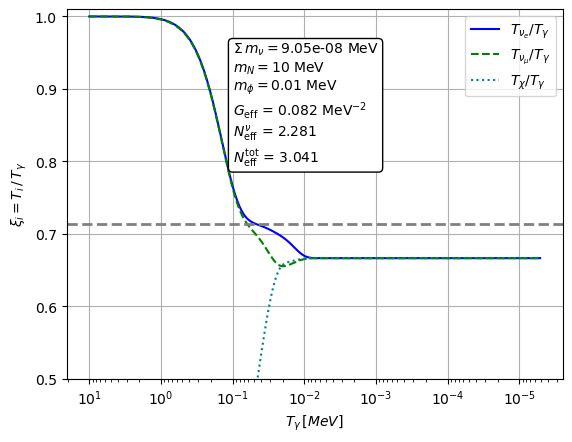

In [50]:
N_eff_nu = round(Neff_nu(Ty_evnt[-1], Tnu_e_evnt[-1], Tnu_mu_evnt[-1]),4)
N_eff_tot = round(Neff(Ty_evnt[-1], Tnu_e_evnt[-1], Tnu_mu_evnt[-1], Tchi_evnt[-1]),4)

print(f"{N_eff_nu/N_eff_tot:0.3}\n")

plt.plot(Ty_evnt, Tnu_e_evnt/Ty_evnt, 'b', label=r'$T_{\nu_e}/T_\gamma$')
plt.plot(Ty_evnt, Tnu_mu_evnt/Ty_evnt, 'g', ls='dashed', label=r'$T_{\nu_\mu}/T_\gamma$')
plt.plot(Ty_evnt, Tchi_evnt/Ty_evnt, 'teal', ls='dotted', label=r'$T_{\chi}/T_\gamma$')


plt.axhline((4/11)**(1/3), c='gray', ls = 'dashed', lw = 2)

plt.legend(loc='best')
plt.xscale('log')
plt.gca().invert_xaxis()

plt.xlabel(r'$T_{\gamma}\, [MeV]$')
plt.ylabel(r'$\xi_i = T_i\,/\,T_\gamma$')

plt.text(1e-1, 0.8, 
         r"$\Sigma\, m_\nu = $"+f"{m_nl1+m_nl2+m_nl3:.2e} MeV"
         +"\n"+r"$m_N = $"+f"{mN1} MeV"
         +"\n"+r"$m_\phi = $"+f"{Mass_phi:.3} MeV"
         +"\n"+r"$G_\text{eff}$ = "+f"{Geffchi:.2}"+" MeV$^{-2}$"
         +"\n"+r"$N^\nu_\text{eff}$ = "+f"{N_eff_nu:.4}"
         +"\n"+r"$N^\text{tot}_\text{eff}$ = "+f"{N_eff_tot:.4}", 
         color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

plt.ylim(0.5,1.01)

plt.grid()
plt.show()

In [10]:
templist = []
Neffneutlist = []
Nefftotlist = []

templist2 = []
Neffneutlist2 = []
Nefftotlist2 = []

for idd in range(160,600):
    templist.append(Ty_mN10[idd])
    Neffneutlist.append(Neff_nu(Ty_mN10[idd], Tnue_mN10[idd], Tnumu_mN10[idd]))
    Nefftotlist.append(Neff(Ty_mN10[idd], Tnue_mN10[idd], Tnumu_mN10[idd], Tchi_mN10[idd]))
    
    templist2.append(Ty_mN100[idd])
    Neffneutlist2.append(Neff_nu(Ty_mN100[idd], Tnue_mN100[idd], Tnumu_mN100[idd]))
    Nefftotlist2.append(Neff(Ty_mN100[idd], Tnue_mN100[idd], Tnumu_mN100[idd], Tchi_mN100[idd]))

templist = np.array(templist)
Neffneutlist = np.array(Neffneutlist)
Nefftotlist = np.array(Nefftotlist)

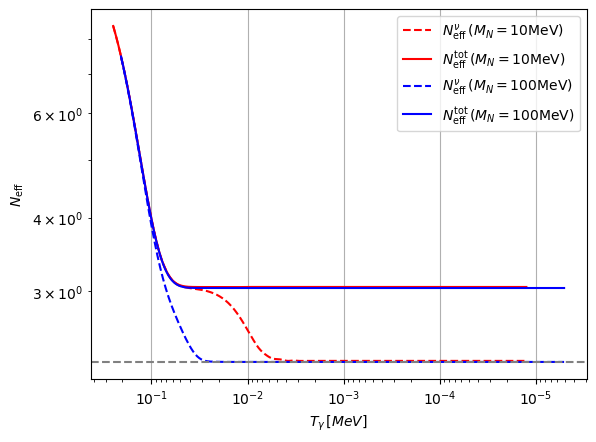

In [12]:
plt.plot(templist, Neffneutlist, color = 'red', ls = 'dashed', 
         label = r'$N_{\rm eff}^{\nu} \, (M_N = 10 {\rm MeV})$')
plt.plot(templist, Nefftotlist, color = 'red', 
         label = r'$N_{\rm eff}^{\rm tot}\, (M_N = 10 {\rm MeV})$')

plt.plot(templist2, Neffneutlist2, color = 'blue', ls = 'dashed', 
         label = r'$N_{\rm eff}^{\nu}\, (M_N = 100 {\rm MeV})$')
plt.plot(templist2, Nefftotlist2, color = 'blue', 
         label = r'$N_{\rm eff}^{\rm tot}\, (M_N = 100 {\rm MeV})$')

plt.axhline(3.04*0.75, color = 'gray', ls = 'dashed')

plt.legend(loc = 'best')

plt.xscale('log')
plt.yscale('log')
plt.gca().invert_xaxis()

plt.xlabel(r'$T_{\gamma}\, [MeV]$')
plt.ylabel(r'$N_{\rm eff}$')
plt.grid()

In [75]:
def int_rate(Tphi):
    return MeV_to_invsec*phi_decayW*kn(1, Mass_phi/Tphi)/kn(2, Mass_phi/Tphi)


Tevol = np.logspace(-6, 1, 22)

dddd = []
llll = []
hhhh = []
for ii in range(len(Tevol)):
    dddd.append(int_rate(Tevol[ii]))
    llll.append(int_rate(1e-4)/Hubble(Tevol[ii], Tevol[ii], Tevol[ii], 1e-6, 1e-6, 1, Mass_phi, include_phi))
    hhhh.append(Hubble(Tevol[ii], Tevol[ii], Tevol[ii], 1e-6, 1e-6, 1, Mass_phi, include_phi))

dddd = np.array(dddd)
llll = np.array(llll)
hhhh = np.array(hhhh)

Text(0, 0.5, '$\\Gamma\\,/\\,H$')

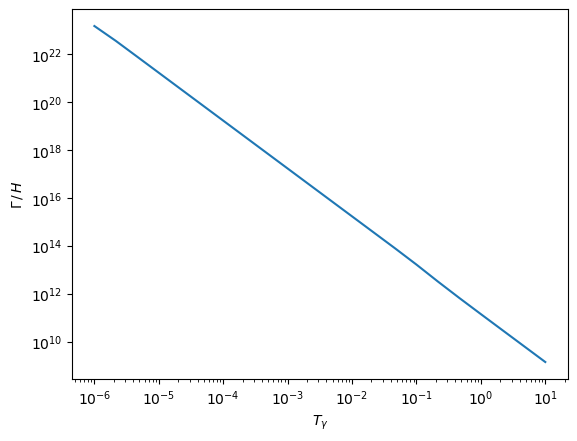

In [76]:
plt.plot(Tevol, llll)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$T_\gamma$')
plt.ylabel(r'$\Gamma\,/\,H$')

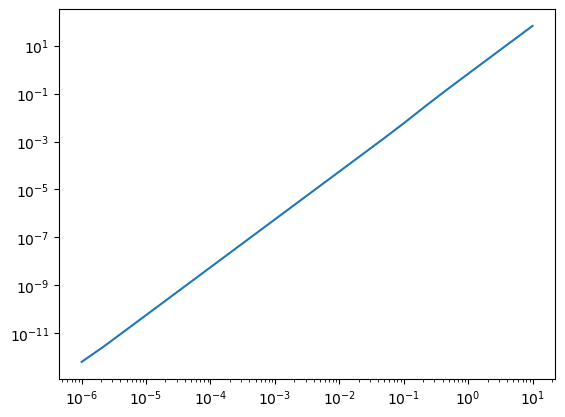

In [77]:
plt.plot(Tevol, hhhh)
plt.xscale('log')
plt.yscale('log')

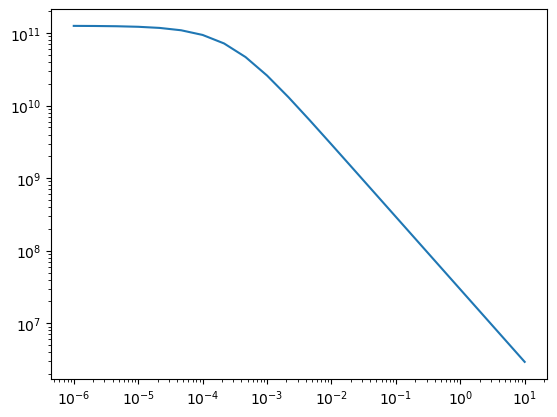

In [78]:
plt.plot(Tevol, dddd)
plt.xscale('log')
plt.yscale('log')